## Titanic: Machine Learning from Disaster

---

### Overview

This is an intro ML competition from Kaggle, described [here](https://www.kaggle.com/c/titanic).

Training data is [here](https://www.kaggle.com/c/titanic/download/train.csv) and validation data is [here](https://www.kaggle.com/c/titanic/download/test.csv).

#### Data Dictionary

Variable | Definition | Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age	| Age in years	
sibsp |	# of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


#### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
**1st** = Upper
**2nd** = Middle
**3rd** = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

*Sibling* = brother, sister, stepbrother, stepsister
*Spouse* = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

*Parent* = mother, father
*Child* = daughter, son, stepdaughter, stepson


### Solution

In [310]:
# start off by ensuring the test and training data have been downloaded.

import os
import tarfile
from six.moves import urllib
import os.path

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
LOCAL_DATA_PATH = './tmp/'

input_files = [TRAIN_FILE, TEST_FILE]
for file in input_files:
    if not os.path.isfile(LOCAL_DATA_PATH + file):
        raise ValueError('Missing file: ' + file)

In [311]:
# display the raw input training data
import pandas as pd

raw_train_df = pd.read_csv(LOCAL_DATA_PATH + TRAIN_FILE)
raw_test_df = pd.read_csv(LOCAL_DATA_PATH + TEST_FILE)
raw_train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [312]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [313]:
# stats of the numeric columns
raw_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [314]:
# 891 rows of 12 columns
raw_train_df.shape

(891, 12)

In [315]:
# we can convert this to a boolean
raw_train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [316]:
# this should be a categorical. there's no real value in the #
raw_train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [317]:
# we might be able to extract some information based on title (mr., Mrs. etc.)
raw_train_df.head(5)['Name']

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [318]:
# we can convert this to a categorical
raw_train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [319]:
# not sure there's any useful info in the ticket #s
raw_train_df['Ticket'].value_counts().head(5)

1601        7
347082      7
CA. 2343    7
3101295     6
CA 2144     6
Name: Ticket, dtype: int64

In [320]:
# we can identify those with multiple cabins (true/false)
# we can also extract deck and room # features
# in cases of multiple cabins, just pick the 'best' deck, aka. closest to A.
raw_train_df['Cabin'].value_counts().head(10)

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
D              3
C22 C26        3
F33            3
E101           3
E25            2
E67            2
Name: Cabin, dtype: int64

In [321]:
# we can convert this to a categorical
raw_train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [322]:
# create a method to transform both the training set and the validation set
# will clean data and perform feature engineering here

# find best cabin if multiple cabins, and extract deck/room numbers
def get_cabin_details(raw_cabin):
    all_cabins = raw_cabin.split(' ')
    best_cabin = sorted(all_cabins)[0]
    
    deck = list(filter(lambda c: not c.isdigit(), best_cabin))[0]
    room_number = ''.join(list(filter(lambda c: c.isdigit(), best_cabin)))
    
    multiple_cabins = len(all_cabins) > 1
    
    return (deck, room_number, multiple_cabins)

def clean_df(raw_df):
    raw_df = raw_df.set_index('PassengerId')
    df = pd.DataFrame(index=raw_df.index)

    # convert survived (ground truth) to boolean column (doesn't exist in test set)
    if 'Survived' in raw_df.columns:
        df['survived'] = raw_df['Survived'].astype('bool')  * 1
    
    # map passenger class to categories
    preference_map = {1: 'upper', 2: 'middle', 3: 'lower'}
    df['p_class'] = raw_df['Pclass'].map(preference_map).astype('category')
    
    # map sex to categories
    df['sex'] = raw_df['Sex'].astype('category')
    
    # copy age directly
    df['age'] = raw_df['Age']
    
    # copy sibling/spouse count directly
    df['sibling_spouse_count'] = raw_df['SibSp'].astype(float)
    
    # copy parent/child count directly
    df['parent_child_count'] = raw_df['Parch'].astype(float)
    
    # copy fare directly
    df['fare'] = raw_df['Fare']
    
    cabin_details = raw_df['Cabin'].dropna().apply(get_cabin_details)
    df['deck'] = cabin_details.apply(lambda x: x[0])
    df['room_number'] = pd.to_numeric(cabin_details.apply(lambda x: x[1]))
    df['multiple_cabins'] = cabin_details.apply(lambda x: x[2])
    
    # map passenger class to categories
    preference_map = {'C': 'cherbourg', 'Q': 'queenstown', 'S': 'southampton'}
    df['embarked_from'] = raw_df['Embarked'].map(preference_map).astype('category')
    
    df = pd.get_dummies(df, columns= ['embarked_from', 'deck', 'sex', 'multiple_cabins', 'p_class'])

    return df

In [323]:
# clean up the training and test sets, then display some summary info on them.
cleaned_train_df = clean_df(raw_train_df)
cleaned_test_df = clean_df(raw_test_df)

In [324]:
cleaned_train_df.tail()

,survived,age,sibling_spouse_count,parent_child_count,fare,room_number,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton,deck_A,...,deck_F,deck_G,deck_T,sex_female,sex_male,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper
PassengerId,,,,,,,,,,,,,,,,,,,,,
887,0,27.0,0.0,0.0,13.00,NaN,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
888,1,19.0,0.0,0.0,30.00,42.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
889,0,NaN,1.0,2.0,23.45,NaN,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
890,1,26.0,0.0,0.0,30.00,148.0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,1
891,0,32.0,0.0,0.0,7.75,NaN,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [325]:
raw_train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [326]:
cleaned_test_df.tail()

,age,sibling_spouse_count,parent_child_count,fare,room_number,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton,deck_A,deck_B,...,deck_E,deck_F,deck_G,sex_female,sex_male,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper
PassengerId,,,,,,,,,,,,,,,,,,,,,
1305,NaN,0.0,0.0,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1306,39.0,0.0,0.0,108.9000,105.0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1307,38.5,0.0,0.0,7.2500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1308,NaN,0.0,0.0,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1309,NaN,1.0,1.0,22.3583,NaN,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [327]:
raw_test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


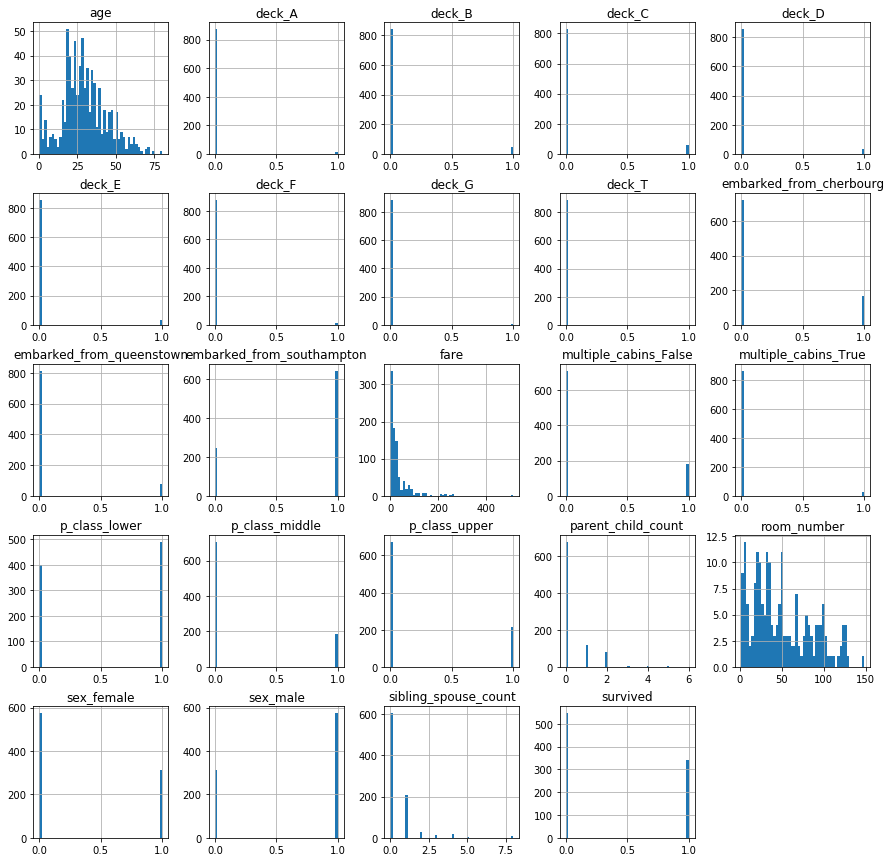

In [328]:
%matplotlib inline 
import matplotlib.pyplot as plt
cleaned_train_df.hist(bins=50, figsize=(15,15))
plt.show()

In [329]:
corr_matrix = cleaned_train_df.corr()
corr_matrix

,survived,age,sibling_spouse_count,parent_child_count,fare,room_number,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton,deck_A,...,deck_F,deck_G,deck_T,sex_female,sex_male,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper
survived,1.000000,-0.077221,-0.035322,0.081629,0.257307,-0.052910,0.168240,0.003650,-0.155660,0.022287,...,0.047930,0.016040,-0.026456,0.543351,-0.543351,0.304115,0.068251,-0.322308,0.093349,0.285904
age,-0.077221,1.000000,-0.308247,-0.189119,0.096067,0.072952,0.036261,-0.022405,-0.032523,0.136309,...,-0.083970,-0.077296,0.039474,-0.093254,0.093254,0.278106,-0.039977,-0.312271,0.006954,0.348941
sibling_spouse_count,-0.035322,-0.308247,1.000000,0.414838,0.159651,-0.058728,-0.059528,-0.026354,0.070941,-0.046266,...,-0.002439,-0.001402,-0.015907,0.114631,-0.114631,-0.068838,0.065717,0.092548,-0.055932,-0.054582
parent_child_count,0.081629,-0.189119,0.414838,1.000000,0.216225,-0.113184,-0.011069,-0.081228,0.063036,-0.040325,...,0.017173,0.072388,-0.015878,0.245489,-0.245489,-0.044021,0.205164,0.015790,-0.000734,-0.017633
fare,0.257307,0.096067,0.159651,0.216225,1.000000,0.060698,0.269335,-0.117216,-0.166603,0.019549,...,-0.032495,-0.025180,0.002224,0.182333,-0.182333,0.326267,0.441953,-0.413333,-0.118557,0.591711
room_number,-0.052910,0.072952,-0.058728,-0.113184,0.060698,1.000000,0.017734,0.095539,-0.032148,-0.242663,...,-0.206040,-0.179289,NaN,-0.045744,0.045744,-0.019857,0.019857,-0.047117,-0.059672,0.078270
embarked_from_cherbourg,0.168240,0.036261,-0.059528,-0.011069,0.269335,0.017734,1.000000,-0.148258,-0.778359,0.093040,...,-0.056322,-0.032371,-0.016158,0.082853,-0.082853,0.186238,0.079306,-0.153329,-0.125416,0.296423
embarked_from_queenstown,0.003650,-0.022405,-0.026354,-0.081228,-0.117216,0.095539,-0.148258,1.000000,-0.496624,-0.040246,...,-0.001283,-0.020654,-0.010310,0.074115,-0.074115,-0.114958,-0.051172,0.237449,-0.127301,-0.155342
embarked_from_southampton,-0.155660,-0.032523,0.070941,0.063036,-0.166603,-0.032148,-0.778359,-0.496624,1.000000,-0.055383,...,0.050608,0.041589,0.020759,-0.125722,0.125722,-0.100547,-0.036345,-0.009511,0.192061,-0.170379
deck_A,0.022287,0.136309,-0.046266,-0.040325,0.019549,-0.242663,0.093040,-0.040246,-0.055383,1.000000,...,-0.015289,-0.008787,-0.004386,-0.078271,0.078271,0.260071,-0.021772,-0.144979,-0.066756,0.231323


In [330]:
corr_matrix['survived'].sort_values(ascending=False)

survived                     1.000000
sex_female                   0.543351
multiple_cabins_False        0.304115
p_class_upper                0.285904
fare                         0.257307
deck_B                       0.175095
embarked_from_cherbourg      0.168240
deck_D                       0.150716
deck_E                       0.150716
deck_C                       0.114652
p_class_middle               0.093349
parent_child_count           0.081629
multiple_cabins_True         0.068251
deck_F                       0.047930
deck_A                       0.022287
deck_G                       0.016040
embarked_from_queenstown     0.003650
deck_T                      -0.026456
sibling_spouse_count        -0.035322
room_number                 -0.052910
age                         -0.077221
embarked_from_southampton   -0.155660
p_class_lower               -0.322308
sex_male                    -0.543351
Name: survived, dtype: float64

## Transformation

Let's build a pipeline to do imputing of missing data etc.

In [331]:
train_x = cleaned_train_df.drop("survived", axis=1).reset_index().drop('PassengerId', axis=1)
train_y = cleaned_train_df["survived"].copy().reset_index().drop('PassengerId', axis=1)

In [332]:
train_y.head()

,survived
0,0
1,1
2,1
3,1
4,0


In [333]:
train_x.head()

,age,sibling_spouse_count,parent_child_count,fare,room_number,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton,deck_A,deck_B,...,deck_F,deck_G,deck_T,sex_female,sex_male,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper
0,22.0,1.0,0.0,7.2500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,38.0,1.0,0.0,71.2833,85.0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2,26.0,0.0,0.0,7.9250,NaN,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,35.0,1.0,0.0,53.1000,123.0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
4,35.0,0.0,0.0,8.0500,NaN,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [334]:
cleaned_train_df.head()

,survived,age,sibling_spouse_count,parent_child_count,fare,room_number,embarked_from_cherbourg,embarked_from_queenstown,embarked_from_southampton,deck_A,...,deck_F,deck_G,deck_T,sex_female,sex_male,multiple_cabins_False,multiple_cabins_True,p_class_lower,p_class_middle,p_class_upper
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1.0,0.0,7.2500,NaN,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,38.0,1.0,0.0,71.2833,85.0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,1,26.0,0.0,0.0,7.9250,NaN,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,1,35.0,1.0,0.0,53.1000,123.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
5,0,35.0,0.0,0.0,8.0500,NaN,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [335]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
age                          714 non-null float64
sibling_spouse_count         891 non-null float64
parent_child_count           891 non-null float64
fare                         891 non-null float64
room_number                  197 non-null float64
embarked_from_cherbourg      891 non-null uint8
embarked_from_queenstown     891 non-null uint8
embarked_from_southampton    891 non-null uint8
deck_A                       891 non-null uint8
deck_B                       891 non-null uint8
deck_C                       891 non-null uint8
deck_D                       891 non-null uint8
deck_E                       891 non-null uint8
deck_F                       891 non-null uint8
deck_G                       891 non-null uint8
deck_T                       891 non-null uint8
sex_female                   891 non-null uint8
sex_male                     891 non-null uint8
multiple_cabins_False

looks like 'age', 'room_number' need to have na's filled in.

In [336]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [337]:
num_columns = train_x.columns[:6]
bool_columns = train_x.columns[5:]

In [338]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion

pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", Pipeline([
        ('selector', DataFrameSelector(list(num_columns))),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])),
    ("bool_pipeline", Pipeline([
        ('selector', DataFrameSelector(list(bool_columns))),
        ('imputer', Imputer(strategy="median")),
    ]))
])

train_x_prepared = pd.DataFrame(pipeline.fit_transform(cleaned_train_df))
train_x_prepared.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.565736,0.432793,-0.473674,-0.502445,-0.118799,-0.482043,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.663861,0.432793,-0.473674,0.786845,2.451511,2.074505,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.258337,-0.474545,-0.473674,-0.488854,-0.118799,-0.482043,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.433312,0.432793,-0.473674,0.420730,4.671325,-0.482043,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.433312,-0.474545,-0.473674,-0.486337,-0.118799,-0.482043,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Alright, I think we've got something we can try training! Let's see..

In [339]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_x_prepared, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [340]:
some_data = train_x.iloc[:5]
some_labels = train_y.iloc[:5]
some_data_prepared = pipeline.transform(some_data)
print("Predictions:\t\t", np.round(lin_reg.predict(some_data_prepared)))
print("Labels:\t\t", some_labels)
# pretty good so far!

Predictions:		 [[ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 0.]]
Labels:		    survived
0         0
1         1
2         1
3         1
4         0


let's try measuring the error:

In [341]:
from sklearn.metrics import mean_squared_error
survival_predictions = lin_reg.predict(train_x_prepared)
lin_mse = mean_squared_error(train_y, survival_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.37218175075048221

hard to interpret an RMSE for a boolean classification like this.. Let's try rounding and see % that match:

In [342]:
predictions_df.head()

,0
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [343]:
label_df.head()

,survived
0,0
1,1
2,1
3,1
4,0


In [344]:
predictions_df = pd.DataFrame(np.round(survival_predictions))
label_df = pd.DataFrame(train_y)
comparison_df = pd.DataFrame()
comparison_df['prediction'] = predictions_df[0].astype(int)
comparison_df['y'] = label_df['survived']
comparison_df['correct'] = comparison_df['y'] == comparison_df['prediction']
len(comparison_df[comparison_df['correct']==True]) / len(comparison_df)

0.8080808080808081

~80%, not bad for a first pass!